### Análise Exploratória Inicial

Essa etapa servirá para entender a estrutura e o conteúdo dos datasets fornecidos, identificando inconsistências, valores ausentes e possíveis problemas de qualidade nos dados. A partir dessa investigação, é possível levantar hipóteses sobre as causas desses problemas e propor estratégias adequadas de tratamento, que serão implementadas posteriormente em scripts Python voltados à reprodutibilidade. Com os dados tratados, serão feitas as análises para responder o problema de negócio.

### Principais observações feitas:
1. Na **Tabela de registros dos pacientes** existem identificadores únicos de paciente que são inconsistentes, com valor "-2", e esses pacientes também possuem data de nascimento e gêneros incorretos. Junto da remoção desses erros, também serão removidas 14.519 duplicatas encontradas e a coluna "Testing Cost", pois além de pertencer à tabela de informação dos exames, também está com valores incorretos.

   Também existem datas de nascimento com valores impossíveis, como uma idade de 160 anos, sendo importante revisar essa questão com a área de negócio, considerando a premissa de que a idade do paciente é uma informação importante para decidir o local de instalação dos laboratórios.

2. Na **Tabela de informações dos exames** haverá remoção de duplicatas existentes de exame repetido. Além disso, alguns valores de custo da realização dos exames apresentam valor 0, o qual se supõe que não faz sentido. Isso é uma questão importante a ser conversada junto da área de negócio para saber o valor real desses itens, caso realmente não seja 0, visto que pode influenciar nas análises erroneamente.

3. Na **Tabela de informações sobre os laboratórios** há valor nulo presente no Zipcode do laboratório, que será removido por não acrescentar a informação principal da localidade do laboratório. Essa informação disponibilizada corretamente é essencial, considerando a premissa de que um local que já possui um laboratório pode não ser interessante de instalar outro. Além disso, essa tabela também passa pelo problema de identificador com "-2", que também será aplicado uma limpeza.

   Além disso, a coluna de Zipcode precisa ser tratada para ter um total de cinco dígitos, como é o formato dos Estados Unidos, para poder fazer a conexão com as tabelas de ZCTA. Para isso, irei acrescentar valores de 0 à esquerda em zipcodes com menos de 5 dígitos, adotando a premissa de que foram omitidos no momento da conversão do arquivo para CSV.

4. Na **Tabela de dados econômicos por ZCTA**, 95% são duplicatas que irão ser removidas.

5. Na **Tabela de dados demográficos por ZCTA**, algumas informações não agregam às análises, como é o caso da população total (TotalPopulation) ser 0. Filtrando os registros com essa coluna igual a 0, percebe-se que há outras inconsistências, como todas as colunas SexRatio e MedianAgeInYears apresentarem valores NaN. Adotando a premissa de que a informação mais relevante desse conjunto de dados para o objetivo das análises é a quantidade total da população e a distribuição da população por faixas etárias, é importante alinhar com a área de negócio a necessidade de corrigir esses campos, que são cruciais para a análise.


### Importação das Bibliotecas

In [499]:
# Para importação e manipulação de dados
import pandas as pd

# Para lidar com datas
from datetime import datetime

# Para construção de gráficos
import plotly.graph_objects as go

# Para não aparecer mensagens de aviso
import warnings
warnings.filterwarnings(action='ignore')

# Para mostrar todas as colunas
pd.set_option('display.max_columns', None)

### Tabela 1: Registros de exames feitos pelos pacientes

In [500]:
# Registros de exames feitos por pacientes da rede em cada laboratório
registros_exames = pd.read_csv('C:/Users/USER/Documents/GitHub/desafio-EloGroup/data/raw/transactional_data (1).csv', sep=';')
registros_exames

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70003237,"9,0"
1,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000638,"13,0"
2,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70001597,"49,0"
3,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000103,"11,0"
4,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000224,"10,0"
...,...,...,...,...,...,...,...,...
2355236,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004038,"10,0"
2355237,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004134,"10,0"
2355238,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70003056,"9,0"
2355239,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004185,"13,0"


#### Informações gerais do conjunto de dados

In [501]:
registros_exames.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355241 entries, 0 to 2355240
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Patient Id       2355241 non-null  object
 1   Gender           2355241 non-null  object
 2   Date of birth    2355240 non-null  object
 3   Date of service  2355241 non-null  object
 4   Service Id       2355241 non-null  object
 5   Lab Id           2355241 non-null  object
 6   CodItem          2355241 non-null  int64 
 7   Testing Cost     2355241 non-null  object
dtypes: int64(1), object(7)
memory usage: 143.8+ MB


- O conjunto de dados registra exames realizados por pacientes da rede em cada laboratório, com informações como ID do paciente, sexo, data de nascimento e chaves que se conectam a possíveis tabelas dimensionais: Service Id (serviço), Lab Id (laboratório) e CodItem (tipo de exame). No total, são 8 colunas e 2.355.241 registros de exames.

- Há apenas um valor nulo, presente na coluna de data de nascimento, Date of birth.

#### Duplicatas

In [502]:
duplicatas_registros_exames = registros_exames[registros_exames.duplicated()]
duplicatas_registros_exames

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
110,10240091057-BIO010,F,12/07/1976 00:00:00,2019-01-09,430000507035-168,L536,70005005,"59,0"
325,10240100137-BIO010,F,19/01/1987 00:00:00,2019-02-03,431300349554-172,L539,70000180,"12,0"
326,10240100137-BIO010,F,19/01/1987 00:00:00,2019-02-03,431300349554-172,L539,70000180,"12,0"
731,10210824046-BIO003,F,13/04/1957 00:00:00,2019-01-15,576401751254-89,L166,70000180,"12,0"
732,10210824046-BIO003,F,13/04/1957 00:00:00,2019-01-15,576401751254-89,L166,70000180,"12,0"
...,...,...,...,...,...,...,...,...
2354236,6004062388-1,F,13/09/1986 00:00:00,2021-01-13,6004062388-3-1,L139,70000819,"30,0"
2354238,6004062388-1,F,13/09/1986 00:00:00,2021-01-13,6004062388-3-1,L139,70006315,"26,0"
2354554,7664121334-1,F,07/11/1947 00:00:00,2021-02-09,7664121334-2-1,L155,70002747,"81,0"
2354885,7658735373-1,M,08/11/1978 00:00:00,2021-01-29,7658735373-15-1,L158,70000180,"12,0"


In [503]:
print(f'Proporção de duplicatas: {round(len(duplicatas_registros_exames) / len(registros_exames), 3)}')

Proporção de duplicatas: 0.006


- Pode-se observar que existem 14.519 (~0.6% do total) linhas totalmente duplicadas no conjunto de dados de registros dos exames. Adotando a premissa de que um paciente pode ter mais de um registro no mesmo dia por realizar diferentes tipos de exame, foi conferido duplicatas em que os valores da linha inteira são iguais. 

    Sendo assim, pelo fato de duplicatas serem redundantes por conterem informações repetidas, estas serão removidas.

In [504]:
# Excluindo duplicatas para não atrapalhar as próximas análises
registros_exames.drop_duplicates(inplace=True)

print(f'Quantidade de registros únicos: {len(registros_exames)}')

Quantidade de registros únicos: 2340722


#### Coluna de Idade do paciente (Date of birth)

In [505]:
registros_exames[registros_exames['Date of birth'].isna() == True]

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
1253947,7659985004-1,F,NaN,2020-02-22,7659985004-2-1,L152,70000107,"48,0"


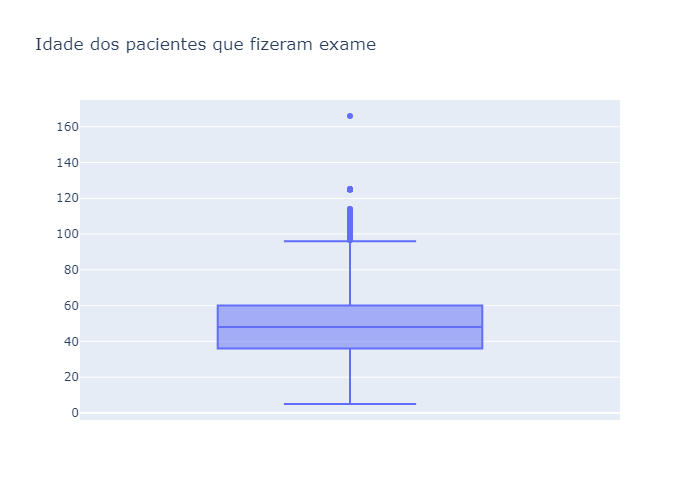

In [506]:
registros_exames['Date of birth'] = pd.to_datetime(registros_exames['Date of birth'], dayfirst=True)

idade_pacientes = datetime.today().year - registros_exames['Date of birth'].dt.year

fig = go.Figure(go.Box(y=idade_pacientes, boxpoints='outliers', name= ' '))
fig.update_layout(title= 'Idade dos pacientes que fizeram exame', showlegend=False)
fig.show('png')

In [507]:
registros_exames[registros_exames['Date of birth'].dt.year <= 1910] # 1910 indica que a pessoa tem pelo menos 125 anos

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
85068,-2,I,1900-01-01,2019-02-22,532800338922-132,L069,70003759,"14,0"
356628,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70000301,"12,0"
356629,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70001276,"53,0"
356630,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70004134,"10,0"
356631,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70003200,"9,0"
356632,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70002619,"12,0"
356633,-2,I,1900-01-01,2019-05-04,571904995402-38,L133,70002141,"47,0"
356634,-2,I,1900-01-01,2019-05-04,571904995402-38,L133,70003239,"47,0"
637178,-2,I,1900-01-01,2019-08-31,569403826990-11,L121,70006532,"0,0"
830128,10225811036-BIO002,M,1859-12-28,2019-09-19,574604575219-67,L152,70004795,"264,0"


- Entre as colunas analisadas, foi identificado um valor nulo na coluna de data de nascimento do paciente. Além disso, por meio do boxplot, observam-se outliers na idade dos pacientes que realizaram exames. Embora seja possível existirem pessoas com idade entre 100 e 115 anos — ainda que raro —, foram encontrados registros com data de nascimento fixada em 1900, indicando possível inconsistência no cadastro. Esses casos coincidem com um ID de paciente igual a -2, sugerindo registros inválidos. Também foi identificado um caso com data de nascimento em 1859, o que implicaria em uma idade de aproximadamente 160 anos, o que é impossível.

- Considerando que pacientes mais idosos tendem a realizar mais exames, sugere-se que é importante que esses dados sejam revisados junto à área de negócios para garantir a qualidade da informação.

#### Coluna Sexo (Gender)

In [508]:
registros_exames['Gender'].value_counts()

Gender
F    1491030
M     849683
I          9
Name: count, dtype: int64

In [509]:
registros_exames[registros_exames['Gender'].isin(['I'])]

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
85068,-2,I,1900-01-01,2019-02-22,532800338922-132,L069,70003759,"14,0"
356628,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70000301,"12,0"
356629,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70001276,"53,0"
356630,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70004134,"10,0"
356631,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70003200,"9,0"
356632,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70002619,"12,0"
356633,-2,I,1900-01-01,2019-05-04,571904995402-38,L133,70002141,"47,0"
356634,-2,I,1900-01-01,2019-05-04,571904995402-38,L133,70003239,"47,0"
637178,-2,I,1900-01-01,2019-08-31,569403826990-11,L121,70006532,"0,0"


- A coluna referente ao sexo dos pacientes apresenta um valor não intuitivo indicado com "I", diferente dos valores "M" (Male) e "F" (Female). Analisando a sua presença no dataset, pode-se notar que também está atribuido aos pacientes com Id "-2" como nas datas de nascimento com incosistência na data.

In [510]:
registros_exames[registros_exames['Patient Id'].apply(lambda k: k.startswith('-'))]

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
85068,-2,I,1900-01-01,2019-02-22,532800338922-132,L069,70003759,"14,0"
356628,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70000301,"12,0"
356629,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70001276,"53,0"
356630,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70004134,"10,0"
356631,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70003200,"9,0"
356632,-2,I,1900-01-01,2019-04-04,573200638885-52,L140,70002619,"12,0"
356633,-2,I,1900-01-01,2019-05-04,571904995402-38,L133,70002141,"47,0"
356634,-2,I,1900-01-01,2019-05-04,571904995402-38,L133,70003239,"47,0"
637178,-2,I,1900-01-01,2019-08-31,569403826990-11,L121,70006532,"0,0"


- Investigando mais a fundo, não foram encontrados outros registros com o ID iniciando com "-", como é o caso do "-2". Por serem valores inconsistentes, ou seja, sem números antecedendo o sinal de menos e associados a outras colunas com dados inválidos, considera-se remover esses registros, uma vez que não é possível identificar o paciente com clareza e há indícios de inconsistências que podem impactar negativamente as análises.

#### Coluna de Custo da realização do exame (Testing Cost)

- A coluna **Testing Cost** representa o custo do exame, mas considerando que existe uma tabela para ter informações dos exames, não faz sentido ela também estar nessa tabela por ser redundante. Sendo assim, será removida desta tabela e ficará apenas na tabela de informações dos exames.

### Tabela 2: Informações dos exames

In [511]:
tipo_exames = pd.read_csv('C:/Users/USER/Documents/GitHub/desafio-EloGroup/data/raw/exams_data.csv')
tipo_exames

,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
0,70003237,"MAGNESIO, SORO (EXEMPLO DE EXPRESSAO DE RESULT...",CA,CORELAB,BIOCHEMISTRY,1.78
1,70000638,"HEMOGRAMA, AUTOMATIZADO, SANGUE",CA,HEMATO,BLOOD COUNT,2.46
2,70001597,"FERRITINA, SORO",CA,CORELAB,IMMUNOHORMONE,2.11
3,70000103,"FERRO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE ...",CA,CORELAB,BIOCHEMISTRY,0.80
4,70000224,"CALCIO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE...",CA,CORELAB,BIOCHEMISTRY,1.02
...,...,...,...,...,...,...
1997,70008635,"GENES BRCA1 E BRCA2, MLPA, SANGUE",CA,GENETICS,SPECIAL GENETICS,159.91
1998,70005303,"OBSTETRICA 1§ TRIMESTRE (ENDOVAGINAL), SEGUNDO...",RID,ULTRASOUND,FETAL MEDICINE,111.43
1999,70006441,"HEMOFILIA A, ANALISE DO DNA, SEQUENCIAMENTO, S...",CA,GENETICS,SPECIAL GENETICS,27.03
2000,70004141,"INSULINA, SORO, 90 MIN APOS XXX",CA,CORELAB,IMMUNOHORMONE,5.55


#### Informações gerais do conjunto de dados

In [512]:
tipo_exames.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CodItem       2002 non-null   int64  
 1   Desc Item     2002 non-null   object 
 2   Category      2002 non-null   object 
 3   Family        2002 non-null   object 
 4   Speciality    2002 non-null   object 
 5   Testing Cost  2002 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 94.0+ KB


- O conjunto de dados possui 2002 registros com informações a respeito dos exames, com características como custo de aplicação e outras especificações técnicas como descrição do item, família e especialidade, com identificação única do tipo pela coluna CodItem. Não há nenhum valor nulo.

In [513]:
tipo_exames[tipo_exames.duplicated(subset='CodItem')]

,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
1968,70004701,PROCEDIMENTO DIAGNOSTICO EM PAINEL DE IMUNOIST...,PA,ANATOMO,IMMUNOHISTOCHEMISTRY,362.96


Considerando que cada tipo de exame é único nesta tabela, não pode haver exames com o mesmo identificador CodItem, pois ele é único. Sendo assim, podemos ver acima que há um registro duplicado que precisará ser removido na etapa de limpeza.

In [514]:
# Excluindo duplicatas para não atrapalhar a análise
tipo_exames.drop_duplicates(subset='CodItem', inplace=True)

print(f'Quantidade de registros únicos: {len(tipo_exames)}')

Quantidade de registros únicos: 2001


#### Coluna de Custo da realização do exame (Testing Cost)

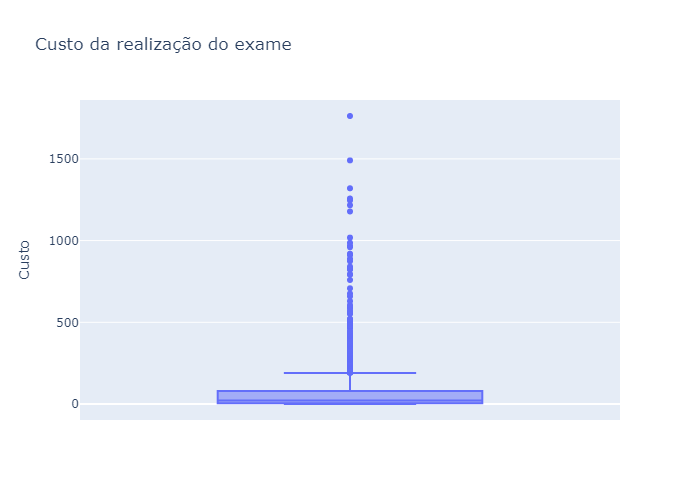

In [515]:
# Plot do boxplot do custo da realização do exame
fig = go.Figure(go.Box(y=tipo_exames['Testing Cost'], boxpoints='outliers', name= ' '))
fig.update_yaxes(title_text="Custo")
fig.update_layout(title= 'Custo da realização do exame', showlegend=False)
fig.show('png')

- A coluna numérica "Testing Cost", que representa o custo da realização dos exames, possui a maioria dos valores concentrados na faixa entre 0 e 250, com mediana próxima de zero, o que indica que a maior parte dos exames possui um custo baixo. Apesar disso, há registros com valores muito mais altos, caracterizados como outliers. 

    Esses valores podem ser possíveis, já que se supõe que alguns exames tenham custo mais elevado do que outros. De qualquer forma, a análise do custo em relação ao tipo de exame realizado exige a validação de um especialista da área, para verificar se os valores são coerentes com os procedimentos registrados. 

In [516]:
# Custo do exame igual a 0
tipo_exames[tipo_exames['Testing Cost'] <= 0]

,CodItem,Desc Item,Category,Family,Speciality,Testing Cost
187,70006809,RM MATERIAIS/MEDICAMENTOS,RID,MRI,MAT / MED,0.0
343,70006810,TC MATERIAIS/MEDICAMENTOS,RID,CT SCAN,MAT / MED,0.0
818,70002489,VOLUME URINARIO,CA,CORELAB,BIOCHEMISTRY,0.0
1536,70001660,"PROLACTINA (BASAL DE PROVA), SORO",CA,CORELAB,IMMUNOHORMONE,0.0
1860,70006904,DERIVADO - DOPPLER TIREOIDE,RID,ULTRASOUND,DOPPLER,0.0
1877,70006910,DERIVADO - DOPPLER ABDOME SUPERIOR,RID,ULTRASOUND,DOPPLER,0.0
1978,70006899,DERIVADO - DOPPLER VASOS CERVICAIS ART,RID,ULTRASOUND,DOPPLER,0.0


- Pode-se observar que alguns valores de custo da realização dos exames apresenta valor 0, o qual se supõe que não faz sentido. Isso é uma questão importante a ser conversada junto da área de negócio para saber o valor desses itens, caso realmente não seja 0, visto que pode influenciar na tabela que essa informação é utilizada. 

In [517]:
registros_exames[['CodItem', 'Testing Cost']].merge(tipo_exames[['CodItem', 'Testing Cost']], on='CodItem', how='left', suffixes=('_Tabela1', '_Tabela2'))

,CodItem,Testing Cost_Tabela1,Testing Cost_Tabela2
0,70003237,"9,0",1.78
1,70000638,"13,0",2.46
2,70001597,"49,0",2.11
3,70000103,"11,0",0.80
4,70000224,"10,0",1.02
...,...,...,...
2340717,70004038,"10,0",1.37
2340718,70004134,"10,0",0.95
2340719,70003056,"9,0",1.12
2340720,70004185,"13,0",2.39


- Curiosamente, além dessa coluna estar presente na tabela principal de registros de exames dos pacientes de forma redundante, nota-se que há evidentemente um erro nos seus valores em comparação a tabela atual de informação dos exames. Logo, isso confirma a remoção necessária dessa informação na tabela anterior de registro de exames dos pacientes.

### Tabela 3: Informações dos laboratórios

In [518]:
# Informações a respeito da localização de cada um dos laboratórios, como endereço, lat-long, e o ZCTA no qual o laboratório se encontra
laboratorios = pd.read_csv('C:/Users/USER/Documents/GitHub/desafio-EloGroup/data/raw/df_geocode (1).csv', index_col=0)
laboratorios

,Lab Id,Address,Location,Zipcode
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0
...,...,...,...,...
114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0
115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0
116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0
117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0


#### Informações gerais do conjunto de dados

In [519]:
laboratorios.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 118
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Lab Id    119 non-null    object 
 1   Address   119 non-null    object 
 2   Location  119 non-null    object 
 3   Zipcode   118 non-null    float64
dtypes: float64(1), object(3)
memory usage: 4.6+ KB


- O conjunto de dados possui 119 registros com informações a respeito da localização de cada um dos laboratórios, como endereço, lat-long e o Zipcode no qual o laboratório se encontra. A identificação única é feita pela chave Lab Id.

- Há apenas um valor nulo, presente na coluna Zipcode.

#### Duplicatas

In [520]:
laboratorios[laboratorios.duplicated(subset='Lab Id')]

,Lab Id,Address,Location,Zipcode


Não há registros duplicados de laboratórios, conforme visto pelo filtro acima através da chave de identificação única.

#### Coluna de Zipcode

In [521]:
laboratorios[laboratorios['Zipcode'].isna() == True]

,Lab Id,Address,Location,Zipcode
83,-2,Unavailable,Unavailable,NaN


- Como pode ser visto, essa coluna não agrega nenhuma informação relevante relacionado à localidade do laboratório. Dessa forma, será feita uma etapa de limpeza de linhas em que não conste informações válidas da localidade, como o próprio Zipcode ou o Lab Id que possui valor -2, semelhante ao ocorrido na tabela de registro de exames.

In [522]:
# Excluindo linha com Zipcode igual NaN e resetando o index do dataset
laboratorios.dropna(subset='Zipcode', inplace=True) 
laboratorios.reset_index(drop=True, inplace=True)

# Transformando a coluna Zipcode de float para int para remover o valor decimal
laboratorios['Zipcode'] = laboratorios['Zipcode'].astype(int)

# Validando a quantidade de dígitos da coluna Zipcode (sem NaN)
laboratorios['Zipcode'].apply(lambda k: len(str(k))).value_counts()

Zipcode
5    97
4    21
Name: count, dtype: int64

- Para a coluna de Zipcode, é necessário haver 5 dígitos, conforme o padrão dos Estados Unidos. Sendo assim, adotarei a premissa de que houve um erro de conversão do CSV fazendo com que valores zeros à esquerda não fossem considerados, o que explicaria a presença de Zipcodes com apenas 4 dígitos. Como existem Zipcodes que podem começar com um ou mais zeros, essa questão será tratada na etapa de limpeza para garantir uma correta interpretação dos dados nas análises.

### Tabela 4: Dados econômicos por ZCTA

In [523]:
# Dados econômicos relevantes a nível de ZCTAs 
dados_economicos_zcta = pd.read_csv('C:/Users/USER/Documents/GitHub/desafio-EloGroup/data/raw/EconomicData_ZCTAs (1).csv', index_col=0)
dados_economicos_zcta

,id,Geographic Area Name,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61
1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26
2,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7
3,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254
4,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249
...,...,...,...,...,...,...,...,...,...,...,...,...
629275,8600000US00979,ZCTA5 00979,735,471,1547,1374,957,1390,662,643,99,319
629276,8600000US00982,ZCTA5 00982,1299,483,1184,848,1104,657,206,79,34,16
629277,8600000US00983,ZCTA5 00983,2638,1368,2495,1845,1906,1952,511,363,110,96
629278,8600000US00985,ZCTA5 00985,2426,1150,2266,1777,1873,1737,501,395,15,26


#### Informações gerais do conjunto de dados

In [524]:
dados_economicos_zcta.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 629280 entries, 0 to 629279
Data columns (total 12 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   id                                  629280 non-null  object
 1   Geographic Area Name                629280 non-null  object
 2   TotalHouseholds_LessThan$10.000     629280 non-null  int64 
 3   TotalHouseholds_$10.000to$14.999    629280 non-null  int64 
 4   TotalHouseholds_$15.000to$24.999    629280 non-null  int64 
 5   TotalHouseholds_$25.000to$34.999    629280 non-null  int64 
 6   TotalHouseholds_$35.000to$49.999    629280 non-null  int64 
 7   TotalHouseholds_$50.000to$74.999    629280 non-null  int64 
 8   TotalHouseholds_$75.000to$99.999    629280 non-null  int64 
 9   TotalHouseholds_$100.000to$149.999  629280 non-null  int64 
 10  TotalHouseholds_$150.000to$199.999  629280 non-null  int64 
 11  TotalHouseholds_$200.000OrMore      629280 n

- O dataset contém 629.280 registros e 12 colunas, todas completas, sem valores nulos. Ele inclui identificadores (id), ZCTAs (Geographic Area Name) e a quantidade de domicílios por faixa de renda anual, detalhadas da seguinte forma: menos de $10.000; entre $10.000 e $14.999; entre $15.000 e $24.999; entre $25.000 e $34.999; entre $35.000 e $49.999; entre $50.000 e $74.999; entre $75.000 e $99.999; entre $100.000 e $149.999; entre $150.000 e $199.999; e mais de $200.000.

#### Duplicatas

In [525]:
duplicatas_dados_economicos_zcta = dados_economicos_zcta[dados_economicos_zcta.duplicated(subset=['id'])]
duplicatas_dados_economicos_zcta

,id,Geographic Area Name,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
33120,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61
33121,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26
33122,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7
33123,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254
33124,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249
...,...,...,...,...,...,...,...,...,...,...,...,...
629275,8600000US00979,ZCTA5 00979,735,471,1547,1374,957,1390,662,643,99,319
629276,8600000US00982,ZCTA5 00982,1299,483,1184,848,1104,657,206,79,34,16
629277,8600000US00983,ZCTA5 00983,2638,1368,2495,1845,1906,1952,511,363,110,96
629278,8600000US00985,ZCTA5 00985,2426,1150,2266,1777,1873,1737,501,395,15,26


In [526]:
print(f'Proporção de duplicatas: {round(len(duplicatas_dados_economicos_zcta) / len(dados_economicos_zcta), 3)}')

Proporção de duplicatas: 0.947


- Como cada id se refere à um identificador de ZCTA e supõe-se que esses valores são únicos para cada região definida por ZCTA, nota-se que há uma grande quantidade de duplicatas, somando 596.160 (~95% do total) valores que repetem informações e apenas ocupam espaço em memória. Logo, essas duplicatas serão removidas.

In [527]:
# Excluindo duplicatas para não atrapalhar a análise
dados_economicos_zcta.drop_duplicates(subset=['id'], inplace=True)

print(f'Quantidade de registros únicos: {len(dados_economicos_zcta)}')

Quantidade de registros únicos: 33120


#### Distribuição estatística de domicílios por classe econômica de todos os ZCTAS

In [528]:
# Descrição estatística dos dados
dados_economicos_zcta.describe()

,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
count,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000
mean,230.234903,160.920380,331.454771,330.243810,451.798581,631.313194,465.690791,553.135386,247.101238,280.055707
std,441.473859,276.897093,520.925224,503.574323,673.915058,927.028673,696.960873,888.380820,469.374301,684.816325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,9.000000,25.000000,25.000000,36.000000,49.000000,31.000000,29.000000,6.000000,3.000000
50%,55.000000,45.000000,98.000000,100.000000,139.000000,195.000000,137.000000,135.000000,40.000000,29.000000
75%,257.000000,188.000000,415.000000,416.000000,578.000000,831.000000,611.000000,681.250000,254.000000,202.000000
max,7901.000000,3942.000000,5410.000000,4349.000000,5988.000000,8466.000000,6491.000000,8705.000000,6095.000000,11968.000000


- Observando a descrição acima dos dados ecônomicos dos ZCTAs, não parece haver nenhum valor que possa ser incosistente.

### Tabela 5: Dados demográficos por ZCTA

In [529]:
# Dados demográficos relevantes a nível de ZCTAs
dados_demograficos_zcta = pd.read_csv('C:/Users/USER/Documents/GitHub/desafio-EloGroup/data/raw/DemographicData_ZCTAs.csv', index_col=0)
dados_demograficos_zcta

,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
0,8600000US35004,ZCTA5 35004,12045,94.1,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5
1,8600000US35005,ZCTA5 35005,7344,86.1,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0
2,8600000US35006,ZCTA5 35006,2883,108.2,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2
3,8600000US35007,ZCTA5 35007,26332,95.0,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7
4,8600000US35010,ZCTA5 35010,20613,90.5,1306,1465,944,1217,1128,2513,2106,2950,1512,1472,2421,1155,424,42.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,8600000US00979,ZCTA5 00979,16130,91.6,402,532,554,726,1005,1935,2109,2468,1368,1148,1974,1363,546,48.7
33116,8600000US00982,ZCTA5 00982,14346,81.0,431,952,795,769,854,1975,1446,1769,957,948,1201,1654,595,44.8
33117,8600000US00983,ZCTA5 00983,33947,81.4,1833,1589,1841,2203,2957,4809,3712,4081,1930,1574,4003,2405,1010,40.8
33118,8600000US00985,ZCTA5 00985,31682,82.4,1171,1427,1833,2304,2032,3491,3966,4073,1732,2047,4207,2498,901,43.6


#### Informações gerais do conjunto de dados

In [530]:
dados_demograficos_zcta.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 33120 entries, 0 to 33119
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Id                               33120 non-null  object 
 1   GeographicAreaName               33120 non-null  object 
 2   TotalPopulation                  33120 non-null  int64  
 3   SexRatio(males per 100 females)  32620 non-null  float64
 4   Population_Under5Years           33120 non-null  int64  
 5   Population_5to9Years             33120 non-null  int64  
 6   Population_10to14Years           33120 non-null  int64  
 7   Population_15to19Years           33120 non-null  int64  
 8   Population_20to24Years           33120 non-null  int64  
 9   Population_25to34Years           33120 non-null  int64  
 10  Population_35to44Years           33120 non-null  int64  
 11  Population_45to54Years           33120 non-null  int64  
 12  Population_55to59Years 

- O dataset contém 33.120 registros e 18 colunas, das quais 16 estão completas e 2 apresentam valores nulos (SexRatio e MedianAgeInYears). As colunas incluem identificadores (Id), ZCTAs (GeographicAreaName), população total e distribuída por faixas etárias (de menos de 5 anos até 85 anos ou mais), além da razão de sexo (número de homens por 100 mulheres) e da mediana de idade em anos.

#### Duplicatas

In [531]:
duplicatas_dados_demograficos_zcta = dados_demograficos_zcta[dados_demograficos_zcta.duplicated(subset=['Id'])]
duplicatas_dados_demograficos_zcta

,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears


- Não existem duplicatas nesse conjunto referente à dados demográficos a nível de ZCTA.

In [532]:
dados_demograficos_zcta.describe()

,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
count,33120.000000,32620.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,32551.000000
mean,9903.343961,116.842275,601.164674,613.889312,637.866304,646.958333,671.606220,1371.989463,1249.675604,1283.429499,660.344807,613.378502,902.903895,458.470954,191.666395,42.699263
std,14714.043400,1483.160382,995.953840,995.199535,1025.828850,1050.850817,1236.614357,2326.202024,1993.925809,1925.116570,939.240835,857.368028,1269.069622,681.297975,312.549075,9.105954
min,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.900000
25%,705.750000,91.300000,31.000000,34.000000,37.000000,37.000000,30.000000,66.000000,70.000000,85.000000,52.000000,51.000000,78.000000,37.000000,10.000000,37.100000
50%,2801.000000,98.400000,146.000000,159.000000,173.500000,171.000000,149.000000,298.000000,313.500000,367.000000,211.000000,202.000000,303.000000,151.000000,51.000000,42.000000
75%,13475.250000,107.900000,744.000000,782.000000,816.250000,820.000000,782.250000,1612.000000,1593.000000,1727.250000,921.250000,867.000000,1266.000000,624.000000,242.000000,47.600000
max,128294.000000,265600.000000,17564.000000,14784.000000,12289.000000,13357.000000,23027.000000,28192.000000,23166.000000,18058.000000,7392.000000,7018.000000,26465.000000,16934.000000,4633.000000,98.200000


In [533]:
dados_demograficos_zcta[dados_demograficos_zcta['TotalPopulation'] == 0]

,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
47,8600000US35082,ZCTA5 35082,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
142,8600000US35457,ZCTA5 35457,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
539,8600000US36590,ZCTA5 36590,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
552,8600000US36615,ZCTA5 36615,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
651,8600000US99513,ZCTA5 99513,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32920,8600000US82715,ZCTA5 82715,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
32955,8600000US82936,ZCTA5 82936,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
32981,8600000US83121,ZCTA5 83121,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
33099,8600000US00950,ZCTA5 00950,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


- Observando a descrição estatística dos dados, nota-se que existem algumas informações que não agregam às análises, como é o caso da população total (TotalPopulation) ser 0. Filtrando os registros com essa coluna igual a 0, percebe-se que há outras inconsistências, como todas as colunas SexRatio e MedianInYears apresentarem valores NaN.

- Adotando a premissa de que a informação mais relevante desse conjunto de dados para o objetivo das análises é a quantidade total da população e a distribuição da população por faixas etárias, é importante alinhar com a área de negócio a necessidade de corrigir esses campos, que são cruciais para a análise.